# RP-GPFA: Textured Bouncing-Ball

Recognition Parametrised GPFA (RP-GPFA) recovers a latent variable (the ball) that stochastically modulates
observed pixel intensity.
The Mean and Variance of each pixel remains constant, only higher moments depends on the ball position.

Imports:

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from recognition_parametrised_model import RPM
from utils_process import plot_loss, plot_rpgpfa_summary, plot_rpgpfa_mixture
from utils_demo import generate_2D_latent, generate_skewed_pixel_from_latent 
import torch.nn.functional as F

# Reproducibility
np.random.seed(1)
torch.manual_seed(1)

# GPUs ?
dtype = torch.float64
torch.set_default_dtype(dtype)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Generate Observations:

In [2]:
# Dimension of the observations
num_observation = 20
dim_observation = 20
len_observation = 50
num_inducing = 20

# Oscillation Speed
omega = 0.5

# Oscillations Parameters
Fz = 10  # Sampling Frequency [Hz]
T = int(len_observation / Fz)  # Sample Length [sec]

# Random initializations and Oscillation
theta = 2*np.pi*np.random.rand(num_observation)
z0 = torch.tensor(np.array([np.cos(theta), np.sin(theta)]).T)
zt, _ = generate_2D_latent(T, Fz
                           , omega, z0)

# Distribution parameters
scale_th = 0.15
shape_max_0 = 1000
sigma2 = 0.01

# True Latent
latent_true = zt[:, 1:, 0] .unsqueeze(-1)

# Sample Observations
samples = generate_skewed_pixel_from_latent(latent_true, dim_observation, scale_th=scale_th, sigma2=sigma2)

# Convert Observations
observations = torch.tensor(samples, dtype=dtype, device=device)

Plot Distribution and Typical Sample

Mean1: -5.33e-04| Var1: 1.00e+00
Mean2: 2.63e-03| Var2: 1.01e+00


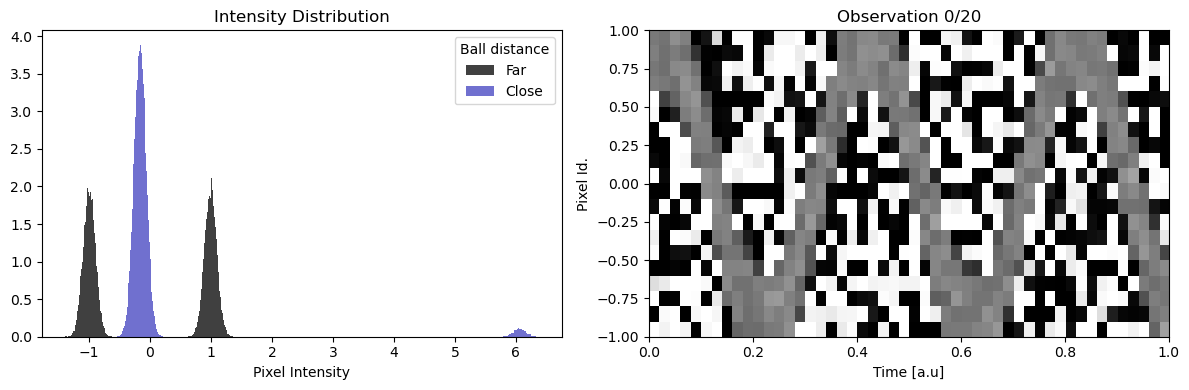

In [3]:
# Sample from distribution
N = 100000
latent_test = torch.empty(N, 3, 1)
latent_test[:, 0, 0] = 1
latent_test[:, 1, 0] = 0
latent_test[:, 2, 0] = -1
observation_samples = generate_skewed_pixel_from_latent(latent_test, 30, scale_th=scale_th, sigma2=sigma2)

# Plot Distribution
plt.figure(figsize=(6 * 2, 4))
plt.subplot(1, 2, 1)
s1 = observation_samples[:, 0, 0]
s2 = observation_samples[:, 0, 24]
plt.hist(s1, bins=500, density=True, alpha=0.75, color=[0.00, 0.00, 0.00], label='Far')
plt.hist(s2, bins=500, density=True, alpha=0.75, color=[0.25, 0.25, 0.75], label='Close')
plt.xlabel('Pixel Intensity')
plt.title('Intensity Distribution')
plt.legend(title='Ball distance')
print('Mean1: %.2e' % s1.mean() + '| Var1: %.2e' % s1.var())
print('Mean2: %.2e' % s2.mean() + '| Var2: %.2e' % s2.var())

# Plot Typical Observation
egobs = 0
pixel_plot = [0, int(dim_observation / 4), 4 * int(dim_observation / 4) -1  ]
plot_observations = not(torch.cuda.is_available())
plt.subplot(1, 2, 2)
plt.imshow(samples[0].transpose(-1, -2), aspect='auto', cmap='gray', extent=[0, 1, -1, 1], vmin=-1, vmax=1)
plt.title('Observation ' + str(egobs) + '/' + str(num_observation))
plt.ylabel('Pixel Id.')
plt.xlabel('Time [a.u]')
plt.tight_layout()

observations = (observations,)



Init and Fit:

In [4]:
# Set up observation / inducing locations
observation_locations = torch.linspace(0, 1, len_observation, dtype=dtype, device=device).unsqueeze(-1)
inducing_locations = observation_locations[
    torch.floor(torch.linspace(0, len_observation - 1, 50)).numpy().astype(int)
]



In [5]:
prior_params = {
    'gp_kernel': 'RBF',
    'scale': 1,
    'lengthscale': 0.1,
    'fit_kernel_scale': False,
    'fit_kernel_scale_prior': False,
    'fit_kernel_lengthscale': True,
    'fit_kernel_lengthscale_prior': True,
    'fit_prior_mean_param': True,
    'optimizer': lambda params: torch.optim.Adam(params=params, lr=1e-3),
}

factors_params = {
    'channels': [[]],
    'kernel_conv': [[]],
    'kernel_pool': [[]],
    'dim_hidden': [[20]],
    'non_linearity': [F.relu],
    'covariance': ['fixed_diag'],
    'optimizer': lambda params: torch.optim.Adam(params=params, lr=1e-3),
}

auxiliary_params = {
    'channels': [[]],
    'kernel_conv': [[]],
    'kernel_pool': [[]],
    'dim_hidden': [[20]],
    'non_linearity': [F.relu],
    'covariance': ['fixed_diag'],
    'optimizer': lambda params: torch.optim.Adam(params=params, lr=1e-3),
    'zero_init': True,
    'fixed':True,
}

variational_params = {
    'inference_mode': 'parametrized',  # 'amortized', 'parametrized'
    'covariance': 'full',
    'optimizer': lambda params: torch.optim.Adam(params=params, lr=1e-3),
}

fit_params = {
    'num_epoch': 5000,
    'dim_latent': 1,
    'prior_params': prior_params,
    'factors_params': factors_params,
    'auxiliary_params': auxiliary_params,
    'variational_params': variational_params,
    'ergodic': True,
}

rpm = RPM(
    observations=observations,
    observation_locations=observation_locations,
    inducing_locations=inducing_locations,
    fit_params=fit_params,
)

rpm.fit(observations)







RPM on CPU Observations on cpu
Epoch 50/5000 Loss: 8.215397e+01
Epoch 100/5000 Loss: 8.732112e+00
Epoch 150/5000 Loss: 8.666788e+00
Epoch 200/5000 Loss: 8.569031e+00
Epoch 250/5000 Loss: 8.446213e+00
Epoch 300/5000 Loss: 8.301667e+00
Epoch 350/5000 Loss: 8.169235e+00
Epoch 400/5000 Loss: 8.110758e+00
Epoch 450/5000 Loss: 8.086103e+00
Epoch 500/5000 Loss: 8.056189e+00
Epoch 550/5000 Loss: 8.029525e+00
Epoch 600/5000 Loss: 8.008250e+00
Epoch 650/5000 Loss: 7.992137e+00
Epoch 700/5000 Loss: 7.979445e+00
Epoch 750/5000 Loss: 7.969264e+00
Epoch 800/5000 Loss: 7.960991e+00
Epoch 850/5000 Loss: 7.954082e+00
Epoch 900/5000 Loss: 7.947797e+00
Epoch 950/5000 Loss: 7.941978e+00
Epoch 1000/5000 Loss: 7.936715e+00
Epoch 1050/5000 Loss: 7.931781e+00
Epoch 1100/5000 Loss: 7.927005e+00
Epoch 1150/5000 Loss: 7.922365e+00
Epoch 1200/5000 Loss: 7.917904e+00
Epoch 1250/5000 Loss: 7.913638e+00
Epoch 1300/5000 Loss: 7.909627e+00
Epoch 1350/5000 Loss: 7.905716e+00
Epoch 1400/5000 Loss: 7.901862e+00
Epoch 145

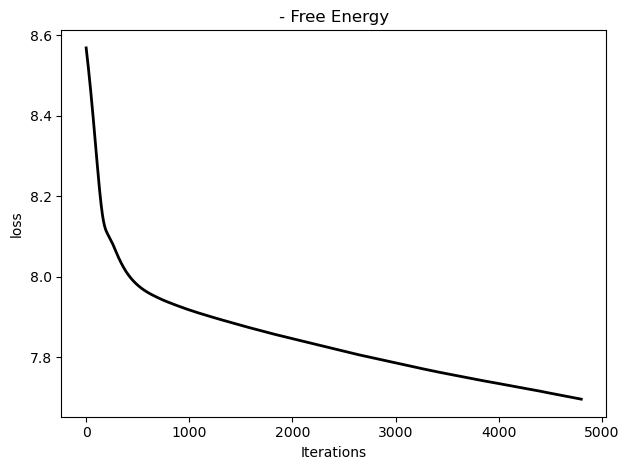

In [9]:
plot_loss(rpm, offset=200)

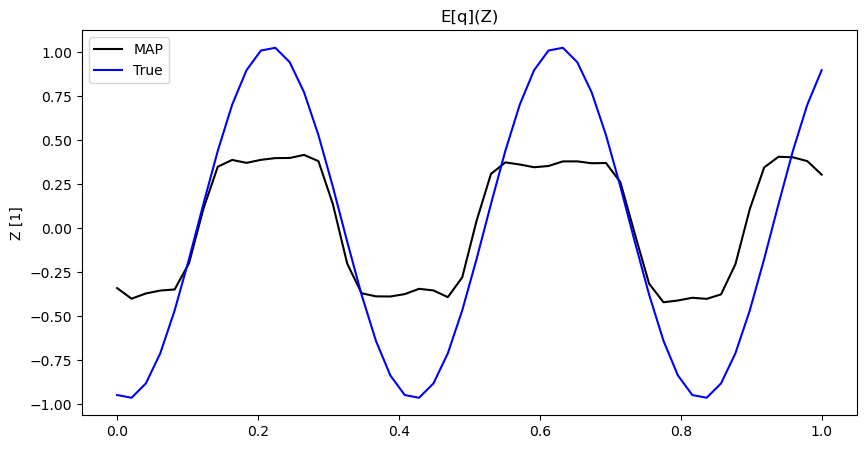

In [10]:
fig = plot_rpgpfa_summary(
    rpm=rpm,
    plot_id_factors=[],
    plot_id_observations=[0],
    plot_variational=True,
    plot_regressed=True,
    plot_variance=False,
    plot_true=True,
    latent_true=latent_true,
    regress_param=None,
    plot_type='linear',
)
fig.set_figwidth(10)
fig.set_figheight(5)

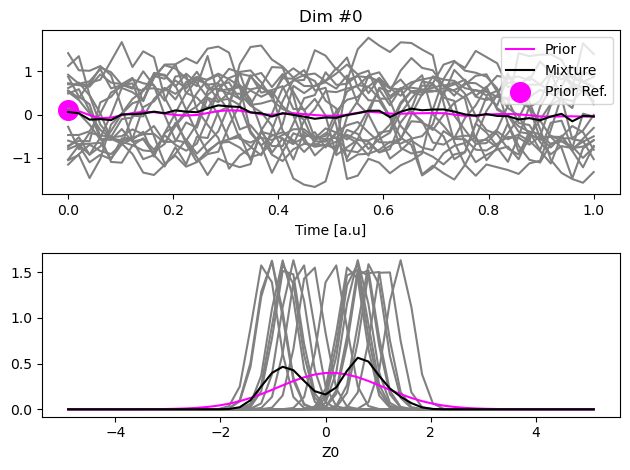

In [11]:
plot_rpgpfa_mixture(
    rpm,
    plot_id_factor = 0,
    plot_id_index = 0,
    plot_locations = 50,
    plot_num_std = 5
)
